<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке предполагается не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# Импорт библиотеки pandas
import pandas as pd
# Импорт библиотеки numpy
import numpy as np
# Импорт библиотеки matplotlib
import matplotlib.pyplot as plt
# Импорт библиотеки math
import math
# Импорт библиотеки time
import time
# Импорт библиотеки sklearn и необходимых компонентов
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
# Удаление ложных предупреждений
pd.options.mode.chained_assignment = None  # default='warn'
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

<font color='DarkBlue'> 
📌 Импортированы все библиотеки, используемые далее в проекте, и скорректированы настройки <br>
</font> 

In [2]:
# Загрузка таблицы в память переменной df типа dataframe
df = pd.read_csv('/datasets/taxi.csv')
# Разделители для удобства отображения информации указаны в виде отдельных пунктов 'print("\033[1m\033[43m {}".format('----- Text -----'),"\033[0m")'
print('\033[1m\033[43m {}'.format('----- Просмотр общей информации о dataframe -----'),'\033[0m')
df.info()
print('\033[1m\033[43m {}'.format('----- Информация о заголовках полей dataframe -----'),'\033[0m')
print(df.columns)
print('\033[1m\033[43m {}'.format('----- Информация о типах полей dataframe -----'),'\033[0m')
print(df.dtypes)
print('\033[1m\033[43m {}'.format('----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа -----'),'\033[0m')
display(df.head())
print('Количество явных дубликатов', df.duplicated().sum())

 ----- Просмотр общей информации о dataframe ----- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
 ----- Информация о заголовках полей dataframe ----- 
Index(['datetime', 'num_orders'], dtype='object')
 ----- Информация о типах полей dataframe ----- 
datetime      object
num_orders     int64
dtype: object
 ----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа ----- 


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Количество явных дубликатов 0


<font color='DarkBlue'> 
📌 В ходе первичного анализа данных сформированы следующие выводы: <br>
    
1. Отсутствует необходимость в редактировании заголовков, названия представлены в условно общепринятом формате 'Змеиный регистр'
2. Пропуски в столбцах не обнаружены
3. Отсутствуют явные дубликаты и, соответственно, необходимость удаления повторяющихся объектов
4. Тип данных числовых полей рекомендуется преобразовать для уменьшения требуемого объема памяти хранения данных, также необходимо конвертировать время в соответствующий тип и заменить соответствующие значения индексов 
5. Среди табличных данных возможно появление некорректных значений, необходимо детально рассмотреть параметры столбцов
</font> 

In [3]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

<font color='DarkBlue'> 
📌 Тип данных столца, содержащего временные значения изменен и обозначен в качестве индекса <br>
📌 Необходимо удостовериться в том, что объекты упорядочены по возрастанию временного интервала и при необходимости отсортировать данные <br>    
</font> 

In [4]:
df.index.is_monotonic
# df = df.sort_index()

True

<font color='DarkBlue'> 
📌 Записи упорядочены последовательно в соответствии с необходимыми требованиями <br>
📌 Необходимо проанализировать свойства столбца с количеством заказов и построить гистограмму распределения и график изменения для наглядности <br>    
</font> 

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


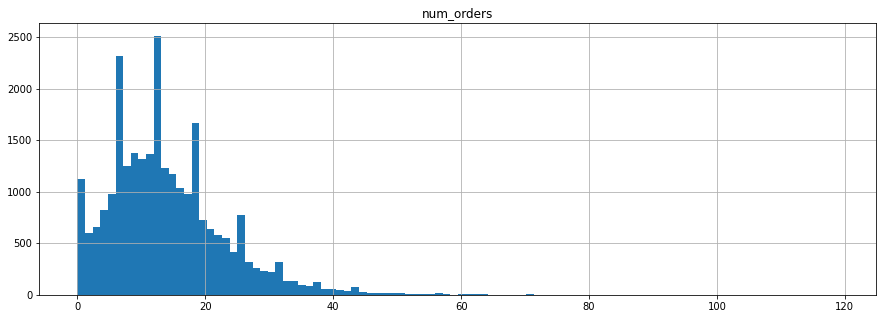

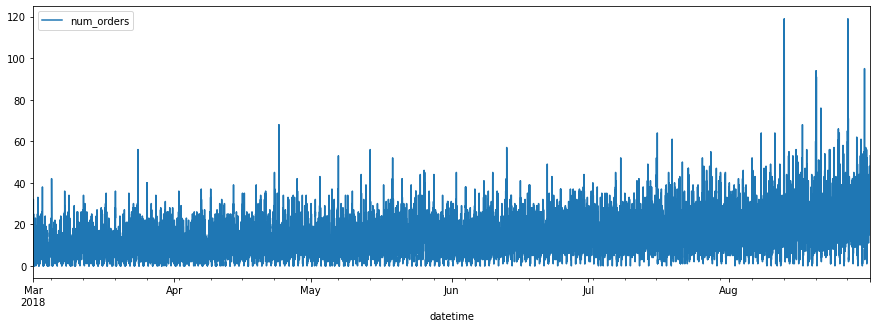

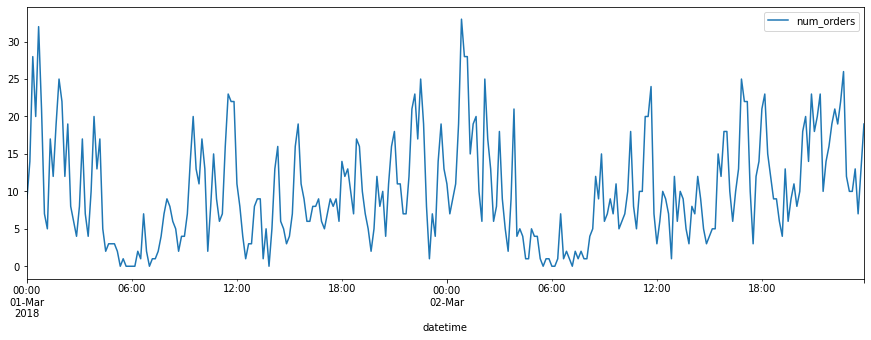

In [5]:
display(df.describe(datetime_is_numeric=True))
df.hist(bins=100, figsize=(15,5))
plt.show()
df.plot(figsize=(15,5))
plt.show()
df['2018-03-01':'2018-03-02'].plot(figsize=(15,5))
plt.show()

<font color='DarkBlue'> 
📌 Присутствует некоторое количество выбивающихся из основного диапазона значений. Минимальное количество заказов - 0, среднее - 14, данные соответствуют действительности <br>    
📌 Значений в исследуемом временном интервале достаточно много, присутствует шум, сопровождающийся частыми изменениями количества заказов независимо от времени. Для того, чтобы присутствовала возможность отследить засвисимости и избавиться от шума предлагается осуществить ресемплирование исходного временного ряда, изменив шаг периодичности с 10 минут до 1 часа <br>
📌 Также необходимо повторить предыдущий анализ на преобразованном датасете <br>    
</font> 

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


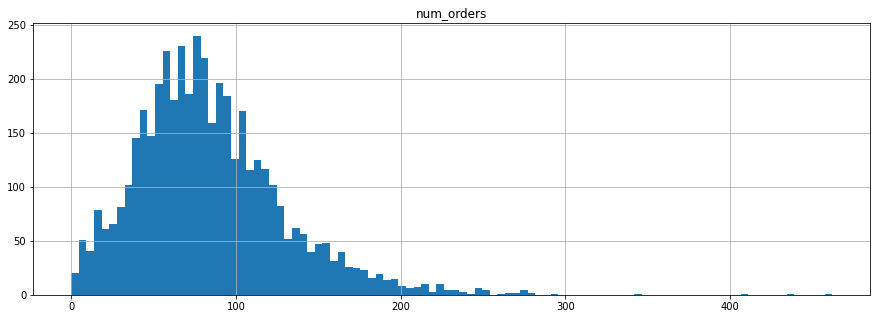

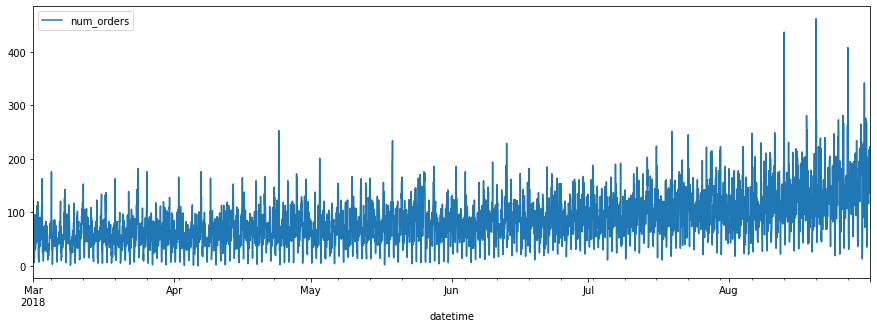

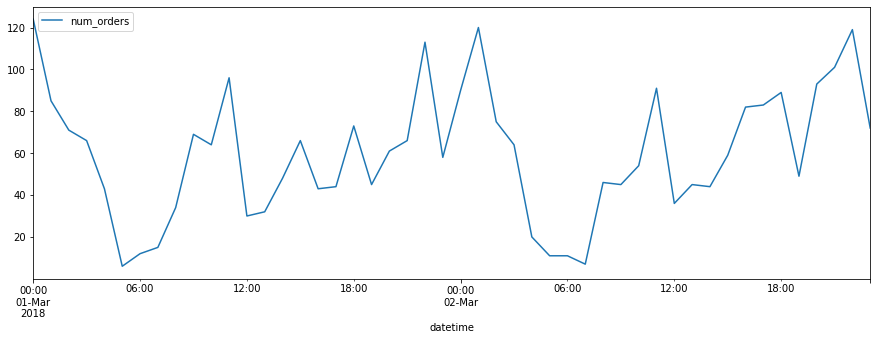

In [6]:
df = df.resample('1H').sum()
display(df.describe(datetime_is_numeric=True))
df.hist(bins=100, figsize=(15,5))
plt.show()
df.plot(figsize=(15,5))
plt.show()
df['2018-03-01':'2018-03-02'].plot(figsize=(15,5))
plt.show()

<font color='DarkBlue'> 
📌 После ресемплирования обнаруживается меньшее количество и значение пиковых зон в соответствии с гистограммой распределения и явно прослеживаются закономерности изменения количества заказов в течение дня в соответствии с укрупненным графиком случайного периода из общей выборки. Преобразованный временной ряд более удобен и информативен для анализа <br>
📌 Для информации желательно отобразить изменение количества заказов с шагом в день. Можно проанализировать недельную сезонность <br>   
</font> 

,num_orders
count,184.000000
mean,2026.146739
std,635.874120
min,1076.000000
25%,1547.500000
50%,1911.500000
75%,2349.750000
max,4090.000000


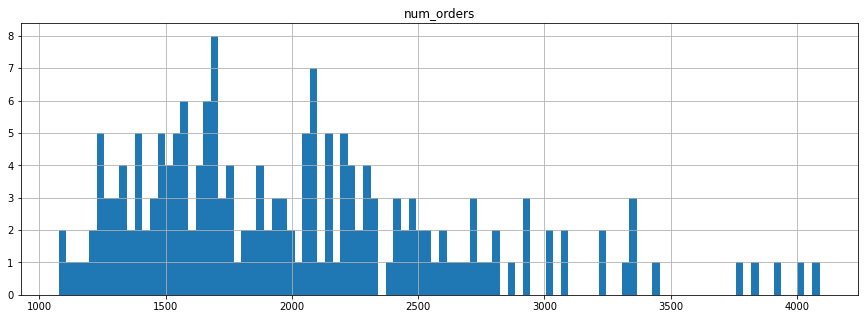

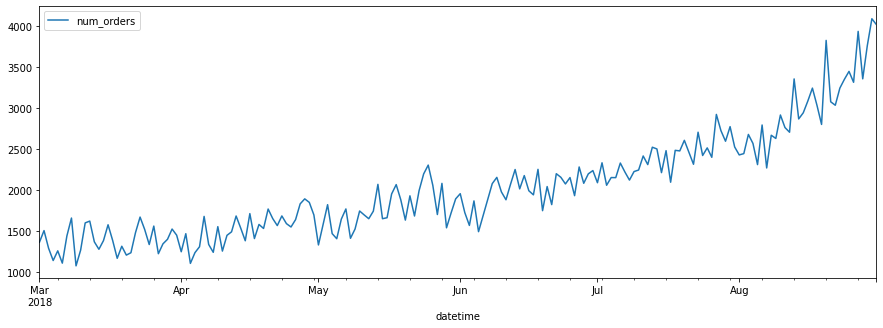

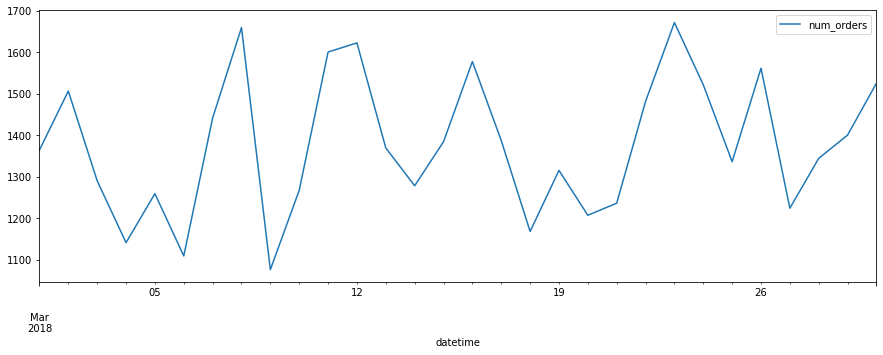

3

In [7]:
display(df.resample('1D').sum().describe(datetime_is_numeric=True))
df.resample('1D').sum().hist(bins=100, figsize=(15,5))
plt.show()
df.resample('1D').sum().plot(figsize=(15,5))
plt.show()
df.resample('1D').sum()['2018-03-01':'2018-03-30'].plot(figsize=(15,5))
plt.show()
print('День недели (0 - понедельник, ..., 6 - воскресенье):', df.index.dayofweek[df.index == '2018-03-01 00:00:00'][0]

<font color='DarkBlue'> 
📌 Исходя из информации на представленных графиках (1 марта 2018 года - четверг), недельная зависимость не наблюдается <br> 
📌 Далее необходимо выполнить преобразование типов данных, если отсутствует необходимость в осуществлении дальнейших арифметических операций с содержимым полей <br>
</font> 

In [8]:
df[df.select_dtypes(include=['int']).columns] = df.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
df[df.select_dtypes(include=['float']).columns] = df.select_dtypes(include=['float']).apply(pd.to_numeric,downcast='float')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   num_orders  4416 non-null   uint16
dtypes: uint16(1)
memory usage: 172.2 KB


## Анализ

<font color='DarkBlue'> 
📌 Можно указать на основном графике временного изменения исследуемого параметра тренд в виде скользящего среднего для наблюдения за тенденцией его изменения <br>
</font> 

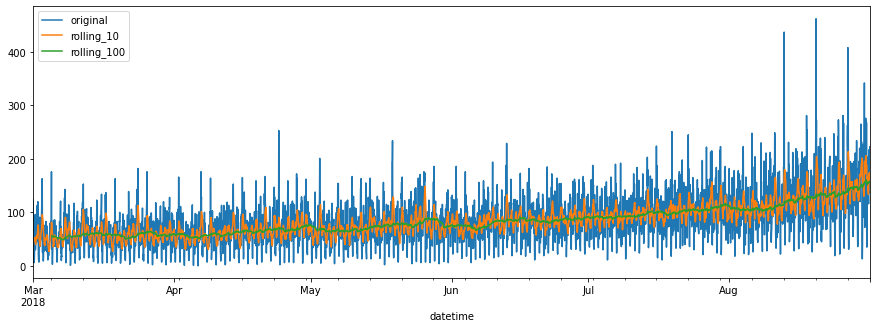

In [9]:
fig, ax = plt.subplots()
df.plot(ax=ax, figsize=(15,5))
df.rolling(10).mean().plot(ax=ax)
df.rolling(100).mean().plot(ax=ax)
plt.legend(['original', 'rolling_10', 'rolling_100'])
plt.show()

<font color='DarkBlue'> 
📌 Заметна тенденция увеличения количества заказов с течением времени. Вероятно, популярность службы увеличивается. Возможно, также зима является более прибыльным сезоном для рассматриваемой отрасли. Для полного анализа рекомендуется наличие выборки за несколько лет <br>
📌 Для дальнейшего анализа дополнительно рекомендуется воспользоваться функцией декомпозиции для выявления сезонности и общего тренда <br>
</font> 

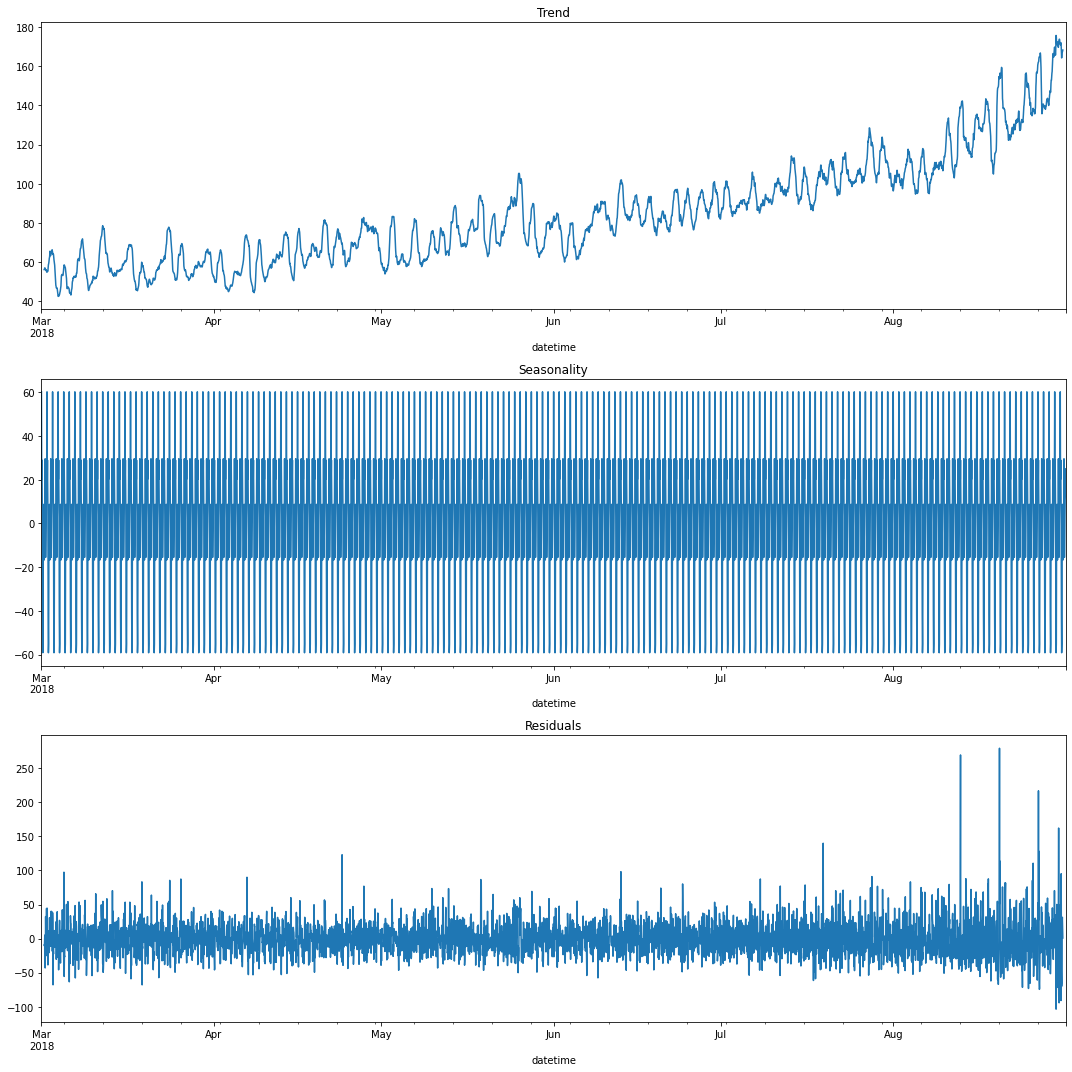

In [10]:
decomposed = seasonal_decompose(df) 
plt.figure(figsize=(15,15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<font color='DarkBlue'> 
📌 Сезонность скорее определена временем суток для каждого дня. Необходимо подробно рассмотреть выборку за несеолько дней <br>
</font> 

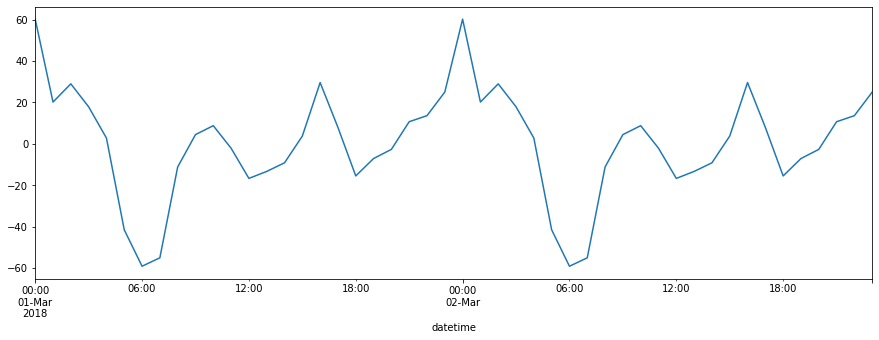

In [11]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(figsize=(15,5))
plt.show()

<font color='DarkBlue'> 
📌 Наблюдается увеличение количества заказов ближе к полуночи, в 9-10 утра и 16-17 вечера, в период движения клиентов к месту работы, учебы и развлекательным заведениям <br>
</font> 

## Обучение

<font color='DarkBlue'> 
📌 Необходимо создать функцию для переиспользования ниже, добавляющую дополнительные признаки для последующего анализа исходного временного ряда с использованием алгоритмов машинного обучения. Предполагается обозначить акцент на времени года, суток, дне недели, также добавить значение скользящего тренда по задаваемому количеству предшествующих записей и указываемое количество полей с разницей между предыдущими значениями временного ряда, где прослеживается более стабильная зависимость по среднему и отклонению параметра <br>
</font> 

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data_conv = data.copy()
    data_conv['rolling_mean'] = data_conv.shift(1).rolling(rolling_mean_size).mean()   
    for lag in range(1, max_lag + 1):
        data_conv['lag_{}'.format(lag)] = data_conv[data_conv.columns[0]].shift(lag)
    # data_conv['month'] = data_conv.index.month
    data_conv['dayofweek'] = data_conv.index.dayofweek
    data_conv['hour'] = data_conv.index.hour
    return data_conv

<font color='DarkBlue'> 
📌 Сначала нужно определить наиболее походящий алгоритм мшинного обучения. Для этого требуется преобразовать исходный датасет и добавить указанные выше выборки. Выбрано небольшое количество дополнительных столбцов для ускорения расчетов и среднее количество предыдущих значений для усреднения параметра: так как разница между записями в 1 час и наблюдается посуточная сезонность, оптимальным параметром будет усреднение за 4 часа <br>
</font> 

In [13]:
df_conv = make_features(df, 2, 4)
df_conv

,num_orders,rolling_mean,lag_1,lag_2,dayofweek,hour
datetime,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,3,0
2018-03-01 01:00:00,85,NaN,124.0,NaN,3,1
2018-03-01 02:00:00,71,NaN,85.0,124.0,3,2
2018-03-01 03:00:00,66,NaN,71.0,85.0,3,3
2018-03-01 04:00:00,43,86.50,66.0,71.0,3,4
...,...,...,...,...,...,...
2018-08-31 19:00:00,136,184.25,207.0,217.0,4,19
2018-08-31 20:00:00,154,189.25,136.0,207.0,4,20
2018-08-31 21:00:00,159,178.50,154.0,136.0,4,21


<font color='DarkBlue'> 
📌 Теперь необходимо разбить данные на обучающую и тестовую выборки в пропорции 9 к 1 для использования в следующем анализе <br>
📌 Отсутствует необходимость в кодировании значений, все переменные числовые <br>    
📌 Далее требуется определить наилучшие гиперпараметры по наименьшенму RMSE для следующих алгоритмов машинного обучения: LinearRegression, RandomForestRegressor, LGBMRegressor, CatBoostRegressor. Также необходимо проверить модели на адекватность (R2 должно быть больше 0) и переобучение <br> 
</font> 

In [14]:
df_train, df_test = train_test_split(df_conv, shuffle=False, test_size=0.1)
df_train = df_train.dropna()
df_features_train, df_features_test = [table.drop('num_orders', axis=1) for table in [df_train, df_test]]
df_target_train, df_target_test = [table.num_orders for table in [df_train, df_test]]

In [15]:
print('features_train:', df_features_train.shape)
print('features_test:', df_features_test.shape)
print('df_target_train:', df_target_train.shape)
print('df_target_test:', df_target_test.shape)

features_train: (3970, 5)
features_test: (442, 5)
df_target_train: (3970,)
df_target_test: (442,)


<font color='DarkBlue'> 
📌 Для удобства формирования дальнейших расчетов можно создать функции обучения моделей и осуществления предсказаний с определением времени и таблицу для фиксации результатов предсказаний <br>
</font> 

In [16]:
def fit(model, cv):     
    if cv == True:
        grid.fit(df_features_train, df_target_train)
        print('Лучшая модель:', grid.best_estimator_)
        print('Параметры лучшей модели:', grid.best_params_)  
        print('Лучшая метрика RMSE:', abs(grid.best_score_) ** 0.5)
        model = grid.best_estimator_
    start_time = time.time()
    model.fit(df_features_train, df_target_train)
    t_train = round((time.time() - start_time) * 1000)
    print('Время обучения:', t_train, 'ms')
    return model, t_train

In [17]:
def predict(model):    
    start_time = time.time()
    df_predicted_test = model.predict(df_features_test)
    t_predict = round((time.time() - start_time) * 1000)
    R2_train = model.score(df_features_train, df_target_train)
    R2_test = model.score(df_features_test, df_target_test)
    RMSE = mean_squared_error(df_target_test, df_predicted_test) ** 0.5
    MAE = mean_absolute_error(df_target_test, df_predicted_test)
    mean = df_predicted_test.mean()
    print('R2 модели на обучающей выборке:', R2_train)
    print('R2 модели на тестовой выборке:', R2_test)
    print('RMSE модели на тестовой выборке:', RMSE)
    print('MAE модели на тестовой выборке:', MAE)
    print('Среднее значение предсказания:', mean)
    print('Время предсказания:', t_predict, 'ms')
    pd.Series(df_target_test).hist(bins=100, label='Факт', alpha=0.5, figsize = (15,5))
    pd.Series(df_predicted_test).hist(bins=np.linspace(df_target_test.min(), df_target_test.max(), num=101), label='Предсказания', alpha=0.5, figsize = (15,5))
    plt.legend()
    plt.show()
    return R2_train, R2_test, RMSE, MAE, mean, t_predict

In [18]:
table = pd.DataFrame(columns = ['name', 'R2_train', 'R2_test', 'RMSE', 'MAE', 'mean', 't_train', 't_predict'])

<font color='DarkBlue'> 
📌 Для обучения модели с использованием алгоритма LinearRegression рекомендуется выполнить масштабирование количественных признаков. Пиковые значения предсказаний никогда не превышают таковые у фактических, поэтому для отображения гистограммы распределений нужно использовать диапазон действительных значений <br> 
</font> 

In [19]:
numeric = df_features_train.select_dtypes(include=['int', 'float', 'float32']).columns
scaler = StandardScaler()
scaler.fit(df_features_train[numeric]) 
df_features_train[numeric] = scaler.transform(df_features_train[numeric])
df_features_test[numeric] = scaler.transform(df_features_test[numeric])
model = LinearRegression()
model, t_train = fit(model, False)

Время обучения: 3 ms


R2 модели на обучающей выборке: 0.3293617213726773
R2 модели на тестовой выборке: 0.06698388091199736
RMSE модели на тестовой выборке: 56.55468336148973
MAE модели на тестовой выборке: 43.439125158943824
Среднее значение предсказания: 115.8878460086829
Время предсказания: 2 ms


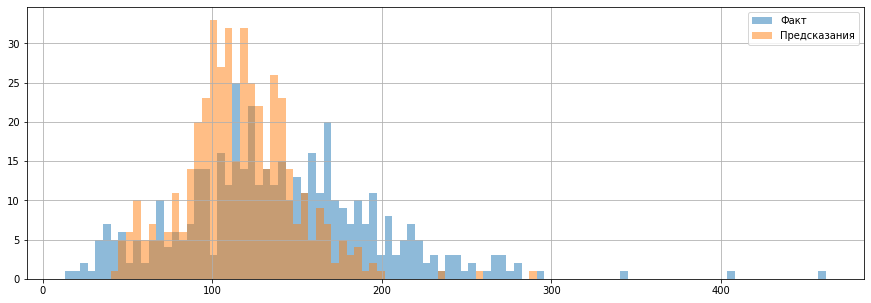

In [20]:
R2_train, R2_test, RMSE, MAE, mean, t_predict = predict(model)
table = table.append({'name': 'LinearRegression', 'R2_train': R2_train, 'R2_test': R2_test, 'RMSE': RMSE, 'MAE': MAE, 'mean': mean, 't_train': t_train, 't_predict': t_predict}, ignore_index=True)

<font color='DarkBlue'> 
📌 На основе отображенной информации можно обозначить следующие выводы:  
    
- время обучения модели достаточно малое, следует учесть, что не осуществлялся перебор по гиперпараметрам
- модель переобучена, так как коэффициенты детерминации на обучающей и валидационной выборках различны по значению
- коэффициент детерминации низкий, но больше 0, соответстственно модель отвечает критерию адекватности
- гистограммы визуально сильно различаются, заментна большая разница между фактическими значениями и предсказанными, сконцентрированными в месте скопления наиболее вероятных, для более подробного анализа необходимо изучить результаты обучения моделей по исходной выборке другими алгоритмами
    
📌 Для обучения модели с использованием алгоритма RandomForestRegressor отсутствует необходимость в масштабировании признаков, поэтому их значения можно вернуть к исходным. Предполагается замена тренировочных и валидационных выборок без создания новых переменных для соответствующего типа кодирования в целях оптимизации производительности выполнения вычислительных процессов в тетради. В дальнейшем учитывается, что перебор гиперпараметров с использованием кроссвалидации самостоятельно разбивает модель на обучающие и валидационные выборки, следовательно, необходимость в ручной операции их разделения отпадает <br> 
</font> 

In [21]:
df_features_train, df_features_test = [table.drop('num_orders', axis=1) for table in [df_train, df_test]]

In [22]:
model = RandomForestRegressor(n_jobs=-1, random_state=12345)
parameters = {'n_estimators': range (31, 51, 10), 'max_depth': range (5, 11)}
grid = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs=-1, cv=TimeSeriesSplit(n_splits=10))
model, t_train = fit(model, True)

Лучшая модель: RandomForestRegressor(max_depth=10, n_estimators=41, n_jobs=-1,
                      random_state=12345)
Параметры лучшей модели: {'max_depth': 10, 'n_estimators': 41}
Лучшая метрика RMSE: 26.070314698294514
Время обучения: 277 ms


R2 модели на обучающей выборке: 0.7975766479638579
R2 модели на тестовой выборке: 0.12586809990168668
RMSE модели на тестовой выборке: 54.7409697156786
MAE модели на тестовой выборке: 41.09514803739848
Среднее значение предсказания: 111.93915682477287
Время предсказания: 8 ms


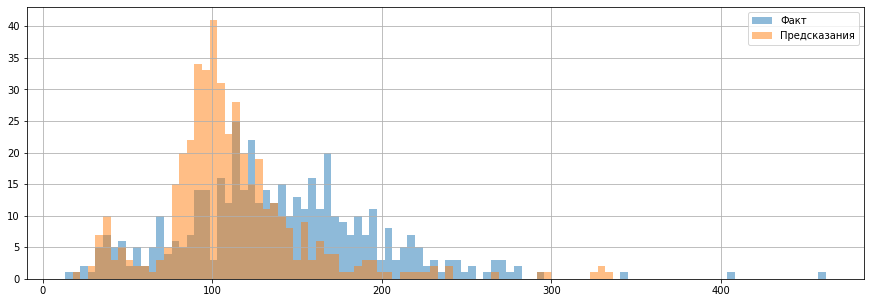

In [23]:
R2_train, R2_test, RMSE, MAE, mean, t_predict = predict(model)
table = table.append({'name': 'RandomForestRegressor', 'R2_train': R2_train, 'R2_test': R2_test, 'RMSE': RMSE, 'MAE': MAE, 'mean': mean, 't_train': t_train, 't_predict': t_predict}, ignore_index=True)

<font color='DarkBlue'> 
📌 На основе указанной информации можно обозначить следующие выводы:  
    
- время обучения небольшое, но выше, чем у предыдущей модели, так как осуществлялся подбор наилучших гиперпараметров для обучения
- качество модели лучше, чем у предыдущего результата, но следует учесть, что метрики усреднены после выполнения перекрестного обучения
- модель сильно переобучена, что характерно для временных рядов, так как коэффициент детерминации по предсказаниям на обучающей выборке заметно больше, чем на валидационной
- гистограммы визуально более похожи по распределениям, но также отсутствуют предсказания со значениями ближе к граничным, модель 'перестраховывается', полагая, что выход значений за определенную зону соответствует аномальным. Для уменьшения фактора сглаживания значений целевого признака можно снизить величину параметра 'max_depth'
    
📌 Для обучения модели с использованием алгоритма LGBMRegressor необходимо использовать существующие выборки, так как алгоритм построен на функционале предыдущего <br> 
</font> 

In [24]:
model = LGBMRegressor(n_jobs=-1, random_state=12345)
parameters = {'n_estimators': range (31, 51, 10), 'max_depth': range (5, 11)}
# 'num_leaves': range (31, 51, 10)
# 'boosting_type': ['gbdt', 'rf', 'dart', 'goss']
# 'learning_rate': [0.1]
grid = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs=-1, cv=TimeSeriesSplit(n_splits=10))
model, t_train = fit(model, True)

Лучшая модель: LGBMRegressor(max_depth=10, n_estimators=41, random_state=12345)
Параметры лучшей модели: {'max_depth': 10, 'n_estimators': 41}
Лучшая метрика RMSE: 25.795386265303836
Время обучения: 603 ms


R2 модели на обучающей выборке: 0.7144789523728363
R2 модели на тестовой выборке: 0.2658529805717105
RMSE модели на тестовой выборке: 50.166698611238616
MAE модели на тестовой выборке: 37.89794412542429
Среднее значение предсказания: 111.98324643241689
Время предсказания: 6 ms


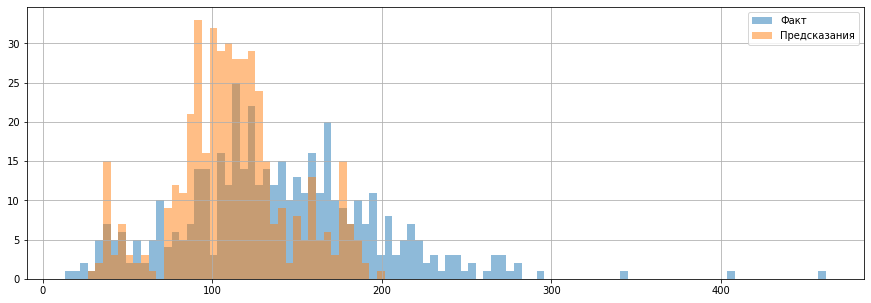

In [25]:
R2_train, R2_test, RMSE, MAE, mean, t_predict = predict(model)
table = table.append({'name': 'LGBMRegressor', 'R2_train': R2_train, 'R2_test': R2_test, 'RMSE': RMSE, 'MAE': MAE, 'mean': mean, 't_train': t_train, 't_predict': t_predict}, ignore_index=True)

<font color='DarkBlue'> 
📌 На основе представленной информации можно обозначить следующие выводы:  
    
- время обучения модели на используемых данных сопоставимо с таковым у предыдущего алгоритма
- качество модели достаточно хорошее, лучше, чем после обучения модели предыдущим алгоритмом
- модель менее переобучена согласно указанным метрикам для обучающей и валидационной выборок
- гистограммы визуально очень похожи по распределениям, отсутствуют предсказания со значением количества заказов более 200 согласно обоснованию, указанному в предыдущих выводах
    
📌 Для обучения модели с использованием алгоритма CatBoostRegressor также можно использовать выборки без их преобразования. Алгоритм перед обучением модели самостоятельно осуществляет кодирование и масштабирование признаков <br> 
</font> 

In [26]:
model = CatBoostRegressor(loss_function='RMSE', random_state=12345, verbose=0)
parameters = {'iterations': range (31, 51, 10), 'depth': range (5, 11)}
# 'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
# 'bootstrap_type': ['Bayesian', 'MVS', 'Poisson', 'No']
# 'boosting_type': ['Ordered', 'Plain']
# 'learning_rate': [0.1]
grid = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs=-1, cv=TimeSeriesSplit(n_splits=10))
model, t_train = fit(model, True)

Лучшая модель: <catboost.core.CatBoostRegressor object at 0x7f962c9afe20>
Параметры лучшей модели: {'depth': 8, 'iterations': 41}
Лучшая метрика RMSE: 26.620726710241904
Время обучения: 583 ms


R2 модели на обучающей выборке: 0.778264101169341
R2 модели на тестовой выборке: 0.12084363287006528
RMSE модели на тестовой выборке: 54.89806848664035
MAE модели на тестовой выборке: 41.05986742614619
Среднее значение предсказания: 107.32295276429548
Время предсказания: 1 ms


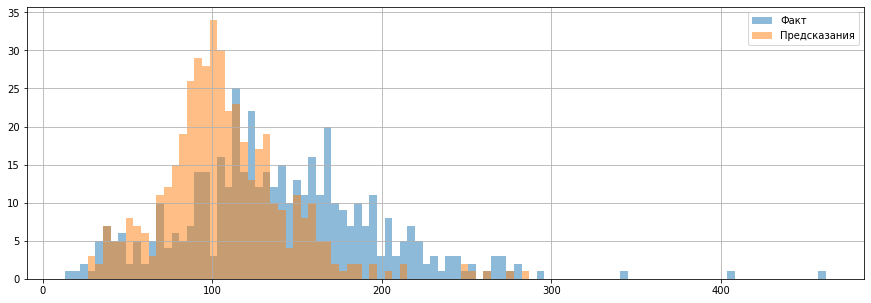

In [27]:
R2_train, R2_test, RMSE, MAE, mean, t_predict = predict(model)
table = table.append({'name': 'CatBoostRegressor', 'R2_train': R2_train, 'R2_test': R2_test, 'RMSE': RMSE, 'MAE': MAE, 'mean': mean, 't_train': t_train, 't_predict': t_predict}, ignore_index=True)

<font color='DarkBlue'> 
📌 На основе представленной информации можно обозначить следующие выводы:  
    
- время обучения модели на используемых данных больше, чем у остальных, в соответствии с концепцией алгоритма, также возможно использовались более значимые наборы гиперпараметров для обучения модели и по умолчанию высокий параметр скорости обучения
- качество модели и метрики приблизительно такие же, как у модели, обученной алгоритмом RandomForestRegressor
- модель также переобучена согласно указанным метрикам для обучающей и валидационной выборок
- графики визуально достаточно похожи по распределениям, гистограмма предсказаний целевого признака распределена на полном интервале его фактических значений, но присутствует меньшее количество наиболее часто встречающихся значений

📌 Теперь с таблицей можно проанализировать результаты обучения модели разными алгоритмами <br>
</font> 

In [28]:
table

,name,R2_train,R2_test,RMSE,MAE,mean,t_train,t_predict
0,LinearRegression,0.329362,0.066984,56.554683,43.439125,115.887846,3,2
1,RandomForestRegressor,0.797577,0.125868,54.740970,41.095148,111.939157,277,8
2,LGBMRegressor,0.714479,0.265853,50.166699,37.897944,111.983246,603,6
3,CatBoostRegressor,0.778264,0.120844,54.898068,41.059867,107.322953,583,1


<font color='DarkBlue'> 
📌 Все обученные модели являются адекватными, но алгоритм LinearRegression показывает заметно худшие результаты обучения согласно представленным метрикам и сравнения гистограмм распределения. Его использование в финальном определении лучшего алгоритма в соответствии с предпочтительными гиперпараметрами не является рекомендуемым  <br> 
📌 В первичном рассмотрении в соответствии со сравнением гистограмм распределения и отсутствием фактора переобучения LightGBM подходит больше, но алгоритм показывает значительно большее время предсказания <br>
📌 Для удобного представления и сравнения желательно также создать таблицу с сохранением параметров обученных моделей и важных для заказчика критериев <br> 
</font> 

In [29]:
table = table[0:0]

<font color='DarkBlue'> 
📌 Следует обучить модель с использованием алгоритма RandomForestRegressor и определить время обучения и предсказания модели <br> 
</font> 

In [30]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=41, max_depth=10, random_state=12345)
model, t_train = fit(model, False)

Время обучения: 287 ms


R2 модели на обучающей выборке: 0.7975766479638579
R2 модели на тестовой выборке: 0.12586809990168668
RMSE модели на тестовой выборке: 54.7409697156786
MAE модели на тестовой выборке: 41.09514803739848
Среднее значение предсказания: 111.93915682477287
Время предсказания: 9 ms


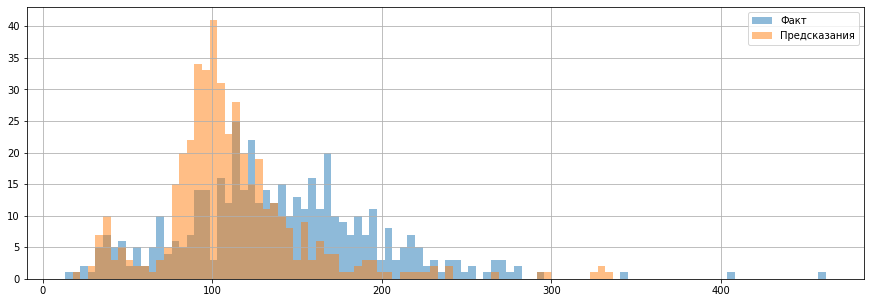

In [31]:
R2_train, R2_test, RMSE, MAE, mean, t_predict = predict(model)
table = table.append({'name': 'RandomForestRegressor', 'R2_train': R2_train, 'R2_test': R2_test, 'RMSE': RMSE, 'MAE': MAE, 'mean': mean, 't_train': t_train, 't_predict': t_predict}, ignore_index=True)

<font color='DarkBlue'> 
📌 Ранее обозначенные выводы для модели соответствуют полученным результатам, на гистограмме заметны периодически выбивающиеся интервалы наиболее частых значений целевого признака. Скорость операций намного выше, чем при переборе гиперпараметров, поэтому изменение соответствующего параметра не заметно <br>
📌 Далее нужно обучить модель с использованием алгоритма LGBMRegressor и определить время обучения и предсказания модели <br> 
</font> 

In [32]:
model = LGBMRegressor(n_jobs=-1, n_estimators=41, max_depth=10, random_state=12345)
model, t_train = fit(model, False)

Время обучения: 469 ms


R2 модели на обучающей выборке: 0.7144789523728363
R2 модели на тестовой выборке: 0.2658529805717105
RMSE модели на тестовой выборке: 50.166698611238616
MAE модели на тестовой выборке: 37.89794412542429
Среднее значение предсказания: 111.98324643241689
Время предсказания: 6 ms


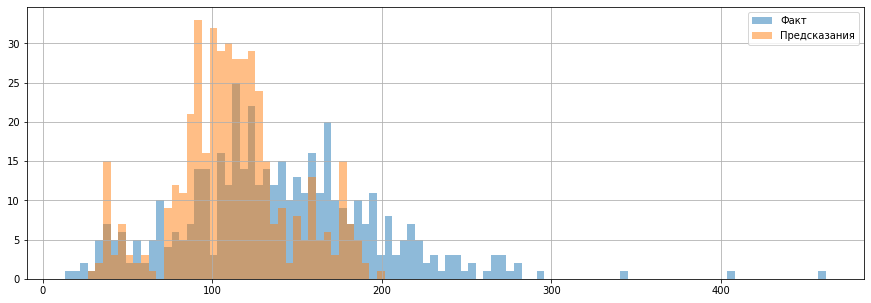

In [33]:
R2_train, R2_test, RMSE, MAE, mean, t_predict = predict(model)
table = table.append({'name': 'LGBMRegressor', 'R2_train': R2_train, 'R2_test': R2_test, 'RMSE': RMSE, 'MAE': MAE, 'mean': mean, 't_train': t_train, 't_predict': t_predict}, ignore_index=True)

<font color='DarkBlue'> 
📌 Метрики определяют лучший результат по отношению к параметрам предыдущей модели <br>
📌 Далее нужно обучить модель с использованием алгоритма CatBoostRegressor и определить время обучения и предсказания модели <br> 
</font> 

In [34]:
model = CatBoostRegressor(loss_function='RMSE', iterations=41, depth=8, random_state=12345, verbose=0)
model, t_train = fit(model, False)

Время обучения: 637 ms


R2 модели на обучающей выборке: 0.778264101169341
R2 модели на тестовой выборке: 0.12084363287006528
RMSE модели на тестовой выборке: 54.89806848664035
MAE модели на тестовой выборке: 41.05986742614619
Среднее значение предсказания: 107.32295276429548
Время предсказания: 1 ms


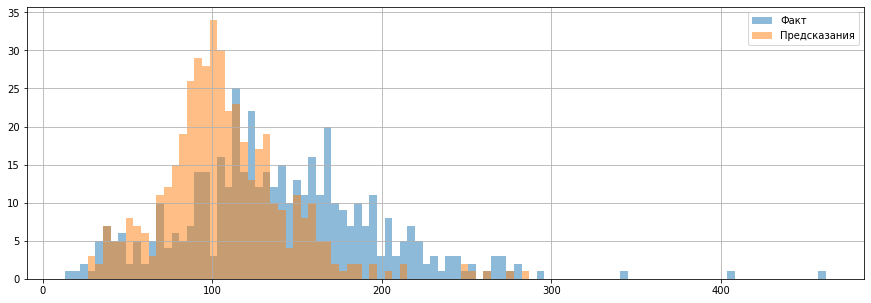

In [35]:
R2_train, R2_test, RMSE, MAE, mean, t_predict = predict(model)
table = table.append({'name': 'CatBoostRegressor', 'R2_train': R2_train, 'R2_test': R2_test, 'RMSE': RMSE, 'MAE': MAE, 'mean': mean, 't_train': t_train, 't_predict': t_predict}, ignore_index=True)

<font color='DarkBlue'> 
📌 Значения метрик очень похожи на соответствующие модели, обученной алгоритмом RandomForestRegressor, но скорость выполнения операций предсказания заметно выше <br> 
📌 Теперь можно вывести на экран таблицу для анализа параметров моделей <br> 
</font> 

In [36]:
table

,name,R2_train,R2_test,RMSE,MAE,mean,t_train,t_predict
0,RandomForestRegressor,0.797577,0.125868,54.740970,41.095148,111.939157,287,9
1,LGBMRegressor,0.714479,0.265853,50.166699,37.897944,111.983246,469,6
2,CatBoostRegressor,0.778264,0.120844,54.898068,41.059867,107.322953,637,1


<font color='DarkBlue'> 
📌 Исходя из указанных данных можно обозначить следующие выводы:
   
- модель RandomForestRegressor скорее имеет среднее качество предсказания, меньшее время обучени модели, что значительно облегчает также реализацию процесса подбора модели, время предсказания имеет наивысшее значение среди представленных алгоритмов
- модель LGBMRegressor имеет лучшее качество предсказания среди указанных в таблице алгоритмов и среднее время обучения, гистограммы фактических значений и предсказаний наиболее точно соответствуют на общем интервале значений, но время предсказания достаточно большое, близкое к соответствующему параметру предыдущей модели  
- модель CatBoostRegressor имеет не лучшее качество предсказания согласно отображаемым метрикам, но удовлетворительное, приближенное к модели, обученной алгоритмом RandomForestRegressor, большее время обучения, чем у остальных моделей, что может являться критичным фактором для ввода в production, и предельно малое время предсказания, чем определяется удобство пользования моделью, в частности для текущей задачи, в которой требуется часто предсказывать предыдущее значение для каждого последующего
    
📌 Согласно отображенным гистограммым все модели больше необходимого предсказывают частые значения. При выборе определенного алгоритма необходимо будет избавиться от фактора переобучения и сгладить график более детальным перебором гиперпараметров. Время предсказания имеет больший приоритет, чем время обучения. Оно очень мало, но в более высокой степени влияет на удобство пользования в данной задаче, соответственно, в текущем контексте качество имеет наибольший вес, затем скорость предсказания модели и обучения. Исходя из того, что у модели CatBoostRegressor согласно метрикам модели, полученной на валидационной выборке, качество приблизительно такое, как у других моделей, гистограмма распределена более широко, и время предсказания значительно ниже, чем у других моделей, выбор ее использования в данном проекте является наиболее подходящим <br> 
</font> 

## Тестирование

<font color='DarkBlue'> 
📌 Для обучения модели с использованием выбранного алгоритма машинного обучения необходимо методом перебора обозначить лучшие параметры определенной ранее функции для добавления признаков, для чего можно создать соответствующую таблицу <br> 
</font> 

In [37]:
table = pd.DataFrame(columns = ['max_lag', 'rolling_mean_size', 'R2', 'RMSE', 'MAE', 'mean'])

In [38]:
%%time
for i in range(1,11):
    for j in range(1,11):
        df_conv = make_features(df, i, j)
        df_train, df_test = train_test_split(df_conv, shuffle=False, test_size=0.1)
        df_train = df_train.dropna()
        df_features_train, df_features_test = [table.drop('num_orders', axis=1) for table in [df_train, df_test]]
        df_target_train, df_target_test = [table.num_orders for table in [df_train, df_test]]
        model = CatBoostRegressor(loss_function='RMSE', iterations=41, depth=8, random_state=12345, verbose=0)
        # model = LGBMRegressor(n_jobs=-1, n_estimators=41, max_depth=10, random_state=12345)
        # model = RandomForestRegressor(n_jobs=-1, n_estimators=41, max_depth=10, random_state=12345)
        model.fit(df_features_train, df_target_train)
        df_predicted_test = model.predict(df_features_test)
        table = table.append({'max_lag': i, 'rolling_mean_size': j, 'R2': model.score(df_features_test, df_target_test), 'RMSE': mean_squared_error(df_target_test, df_predicted_test) ** 0.5, 'MAE': mean_absolute_error(df_target_test, df_predicted_test), 'mean': df_predicted_test.mean()}, ignore_index=True)

CPU times: user 24.6 s, sys: 481 ms, total: 25 s
Wall time: 1min 29s


In [39]:
table

,max_lag,rolling_mean_size,R2,RMSE,MAE,mean
0,1.0,1.0,0.086623,55.956312,43.073268,102.530930
1,1.0,2.0,0.203730,52.246151,40.347757,109.232116
2,1.0,3.0,0.164878,53.505576,41.236482,107.884829
3,1.0,4.0,0.181961,52.955488,40.356330,109.069338
4,1.0,5.0,0.263832,50.235694,38.349581,112.420919
...,...,...,...,...,...,...
95,10.0,6.0,0.326173,48.061603,35.951745,118.917185
96,10.0,7.0,0.380547,46.081660,34.631827,119.940831
97,10.0,8.0,0.344020,47.420845,34.842555,118.944192
98,10.0,9.0,0.309632,48.647923,35.969794,119.940060


<font color='DarkBlue'> 
📌 После выполнения соответствующих операций необходимо определить параметры функции, при которых достигается минимальное значение среднеквадратичного отклонения <br> 
</font> 

In [40]:
table[table['RMSE'] == table['RMSE'].min()]

,max_lag,rolling_mean_size,R2,RMSE,MAE,mean
8,1.0,9.0,0.427354,44.30646,32.83507,118.433322


<font color='DarkBlue'> 
📌 Рекомендуется построить график сравнения фактических значений и наилучшего прогноза <br> 
</font> 

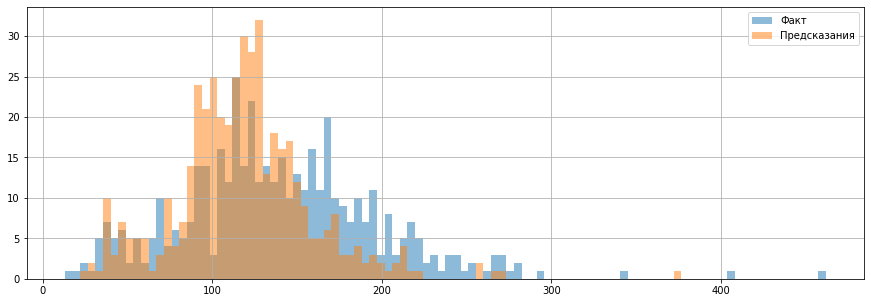

In [41]:
df_conv = make_features(df, 1, 9)
df_train, df_test = train_test_split(df_conv, shuffle=False, test_size=0.1)
df_train = df_train.dropna()
df_features_train, df_features_test = [table.drop('num_orders', axis=1) for table in [df_train, df_test]]
df_target_train, df_target_test = [table.num_orders for table in [df_train, df_test]]
model = CatBoostRegressor(loss_function='RMSE', iterations=41, depth=8, random_state=12345, verbose=0)
model.fit(df_features_train, df_target_train)
df_predicted_test = model.predict(df_features_test)
pd.Series(df_target_test).hist(bins=100, label='Факт', alpha=0.5, figsize = (15,5))
pd.Series(df_predicted_test).hist(bins=np.linspace(df_target_test.min(), df_target_test.max(), num=101), label='Предсказания', alpha=0.5, figsize = (15,5))
plt.legend()
plt.show()

<font color='DarkBlue'> 
📌 Гистограммы на графике имеют достаточно похожие распределения, соответственно, качество модели на данном этапе удовлетворяет заявленным требованиям <br> 
📌 В соответствии с заданием нужно спрогнозировать количество заказов такси на следующий час. Необходимо создать новую запись и присвоить значения признаков, вычисляемые по предшествующим данным <br> 
</font> 

In [42]:
df.loc[df[-1:].index[0] + pd.Timedelta(hours=1)] = [np.nan] * df.shape[1]
df.tail()

,num_orders
datetime,
2018-08-31 20:00:00,154.0
2018-08-31 21:00:00,159.0
2018-08-31 22:00:00,223.0
2018-08-31 23:00:00,205.0
2018-09-01 00:00:00,NaN


In [43]:
df_train = df_conv[:-1].dropna()
df_test = df_conv[-1:]
df_features_train, df_features_test = [table.drop('num_orders', axis=1) for table in [df_train, df_test]]
df_target_train, df_target_test = [table.num_orders for table in [df_train, df_test]]
model = CatBoostRegressor(loss_function='RMSE', iterations=41, depth=8, random_state=12345, verbose=0)
model.fit(df_features_train, df_target_train)
df[-1:] = model.predict(df_features_test)[0]
display(round(df[-1:],6))

,num_orders
datetime,
2018-09-01,207.623516


<font color='DarkBlue'> 
📌 Определено приблизительное количество заказов такси в соответствии с загрузкой в текущее время <br> 
📌 Далее можно спрогнозировать соответствующие значения целевого признака, например, на 3 дня вперед, и отобразить результат на графике. Для этого предполагается использование существующей модели или обучение новой на полной исходной выборке с подобранным алгоритмом и определенными гиперпараметрами. Сначала необходимо удалить спрогнозированное значение <br> 
</font> 

In [44]:
df = df[:-1]

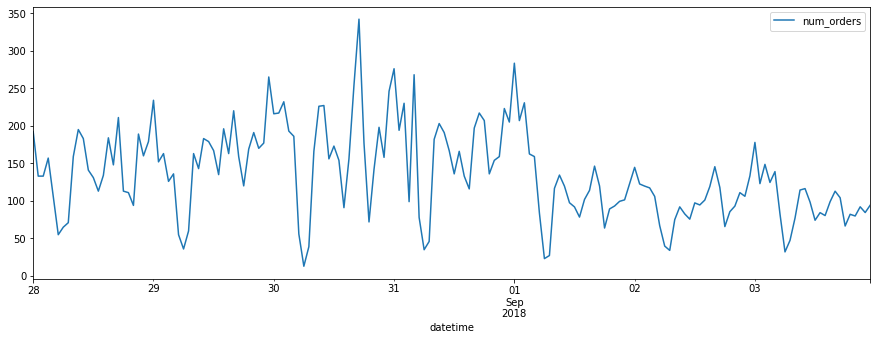

In [46]:
for i in range(72):
    df.loc[df[-1:].index[0] + pd.Timedelta(hours=1)] = [np.nan] * df.shape[1]
    df_conv = make_features(df, 1, 9)    
    if i == 0:
        df_train = df_conv[:-1].dropna()
        df_features_train = df_train.drop('num_orders', axis=1)
        df_target_train = df_train.num_orders
        model = CatBoostRegressor(loss_function='RMSE', iterations=41, depth=8, random_state=12345, verbose=0)
        model.fit(df_features_train, df_target_train)
    df_test = df_conv[-1:]
    df_features_test = df_test.drop('num_orders', axis=1)
    df[-1:] = model.predict(df_features_test)[0]
df['2018-08-28':'2018-09-03'].plot(figsize=(15,5))
plt.show()

<font color='DarkBlue'> 
📌 Согласно графику распределение показаний целевого признака подобно предшествующему на всем интервале <br> 
📌 Можно более детально подобрать наилучшие гиперпараметры для выбранной модели и при необходимости использовать в рабочем пространстве заказчика <br> 
📌 На основании произведенных исследований можно сформировать следующие выводы:
    
- предоставленные данные хорошего качества, отсутствуют дубликаты, пропуски и аномалии, данные отсортированы в порядке возрастания времени
- для более удобного использования необходимо преобразование типов данных в форматы, занимающие меньший объем памяти и использование временных значений соответствующего типа в качестве индексов
- определено, что наилучшим алгоритмом обучения модели для определения количества заказов такси по исходным данным будет являться CatBoostRegressor в соответствии с указанными выше обоснованиями после представленных таблиц, разработан алгоритм подготовки данных (ресемплирование, добавление признаков) для модели и спрогнозировано следующее значение на 00:00 01.09.2018, приходящееся на момент суточной пиковой загрузки
- значение ключевой метрики RMSE согласно анализу предсказаний определения количества заказов на тестовой выборке моделей, выбранных для финального сравнения, меньше 48
</font> 